Credit Card Approval Prediction System
WGU C964 Computer Science Capstone
Author: Blake Mancill

# =============================================================================
# SECTION 1: IMPORTS AND SETUP
# =============================================================================

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTETomek
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, make_scorer, \
    fbeta_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
%matplotlib inline

# =============================================================================
# SECTION 2: DATA LOADING
# =============================================================================

In [80]:
print("\n📁 LOADING DATA...")

application_df = pd.read_csv("https://raw.githubusercontent.com/blakemancill/C964-Credit-Card-App/main/data/application_record.csv")
credit_df = pd.read_csv("https://raw.githubusercontent.com/blakemancill/C964-Credit-Card-App/main/data/credit_record.csv")


📁 LOADING DATA...


In [81]:
print(f"📊 Application Records: {application_df.shape[0]:,} rows, {application_df.shape[1]} columns")
print(f"📊 Credit Records: {credit_df.shape[0]:,} rows, {credit_df.shape[1]} columns")
print(f"👥 Unique Applicants in Application Data: {application_df['ID'].nunique():,}")
print(f"👥 Unique Applicants in Credit Data: {credit_df['ID'].nunique():,}")

📊 Application Records: 438,557 rows, 18 columns
📊 Credit Records: 1,048,575 rows, 3 columns
👥 Unique Applicants in Application Data: 438,510
👥 Unique Applicants in Credit Data: 45,985


# =============================================================================
# SECTION 3: DESCRIPTIVE ANALYSIS
# =============================================================================


📊 DESCRIPTIVE ANALYSIS

Generating histogram for credit records...


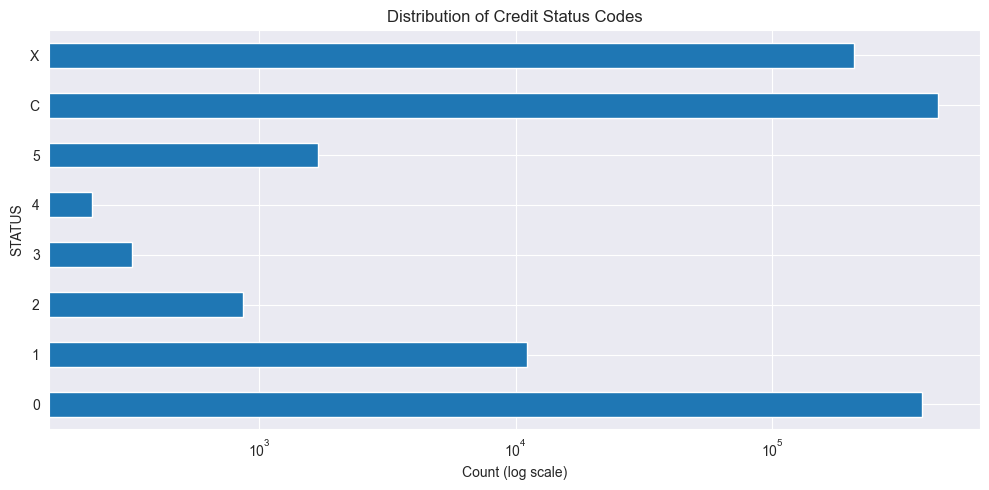

In [82]:
print("\n" + "=" * 60)
print("📊 DESCRIPTIVE ANALYSIS")
print("=" * 60)

print("\nGenerating histogram for credit records...")

# Histogram: Credit STATUS distribution
plt.figure(figsize=(10,5))
vc = credit_df['STATUS'].value_counts().sort_index()
ax = vc.plot(kind='barh')
ax.set_xscale('log')
plt.title("Distribution of Credit Status Codes")
plt.xlabel("Count (log scale)")
plt.ylabel("STATUS")
plt.tight_layout()
plt.show()

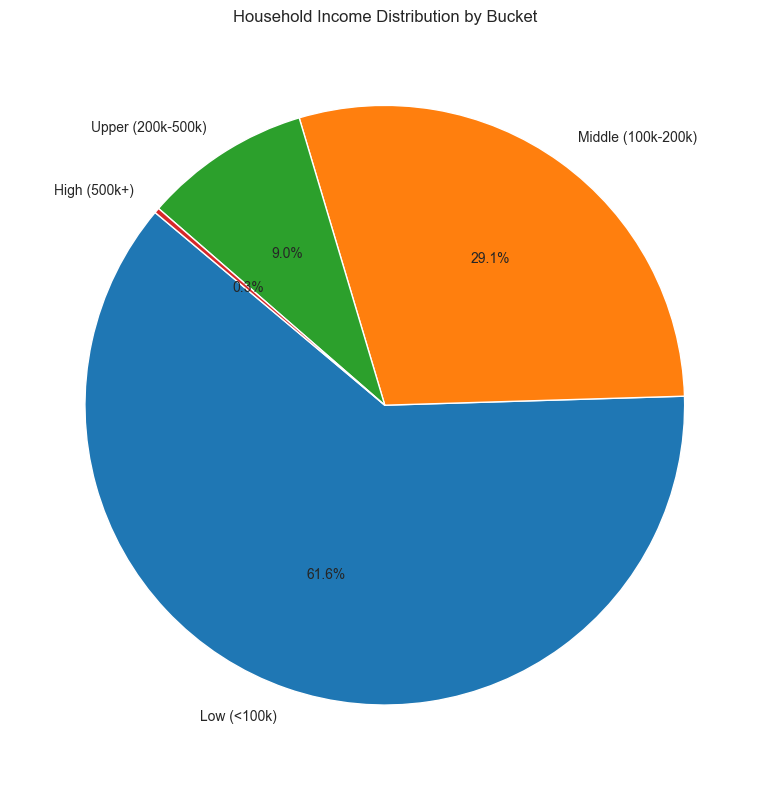

In [83]:
bins = [0, 100000, 200000, 500000, float('inf')]
labels = [
    "Low (<100k)",
    "Middle (100k-200k)",
    "Upper (200k-500k)",
    "High (500k+)"
]
application_df["income_bucket"] = pd.cut(application_df["AMT_INCOME_TOTAL"] / application_df['CNT_FAM_MEMBERS'].replace(0, 1), bins=bins, labels=labels, include_lowest=True)
bucket_counts = application_df["income_bucket"].value_counts().sort_index()
plt.figure(figsize=(8,8))
plt.pie(
    bucket_counts,
    labels=bucket_counts.index,
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Household Income Distribution by Bucket")
plt.tight_layout()
plt.show()

# =============================================================================
# SECTION 4: LABEL ENGINEERING
# =============================================================================

In [84]:
print("\n" + "=" * 60)
print("🏷️ LABEL ENGINEERING")
print("=" * 60)

# Assign Good/Bad based on credit status
credit_df['Good or Bad'] = credit_df['STATUS'].apply(
    lambda x: 'Good' if x in ['0', 'X', 'C'] else 'Bad'
)

# Identify IDs with any bad history
bad_customers = credit_df[credit_df['Good or Bad'] == 'Bad']['ID'].unique()

# Assign labels: 1 = Bad customer, 0 = Good customer
labels = pd.DataFrame({'ID': credit_df['ID'].unique()})
labels['LABEL'] = labels['ID'].apply(lambda x: 1 if x in bad_customers else 0)

print(f"Label distribution from credit history:")
print(f"Strict (30+ days late = bad):")
print(f"  Good: {(labels['LABEL']==0).sum():,} ({(labels['LABEL']==0).sum()/len(labels)*100:.1f}%)")
print(f"  Bad:  {(labels['LABEL']==1).sum():,} ({(labels['LABEL']==1).sum()/len(labels)*100:.1f}%)")


🏷️ LABEL ENGINEERING
Label distribution from credit history:
Strict (30+ days late = bad):
  Good: 40,635 (88.4%)
  Bad:  5,350 (11.6%)


# =============================================================================
# SECTION 5: DATA MERGING AND INITIAL CLEANING
# =============================================================================

In [85]:
print("\n" + "=" * 60)
print("🔗 DATA MERGING")
print("=" * 60)

# Identify customers WITH and WITHOUT credit history
customers_with_history = set(labels['ID'].unique())
all_applicants = set(application_df['ID'].unique())
customers_without_history = all_applicants - customers_with_history

print(f"📊 Applicant Breakdown:")
print(f"   Total applicants:        {len(all_applicants):,}")
print(f"   With credit history:     {len(customers_with_history):,}")
print(f"   Without credit history:  {len(customers_without_history):,}")

# Create dataframe for customers WITHOUT credit history (for future predictions)
new_applicants_df = application_df[application_df['ID'].isin(customers_without_history)].copy()
print(f"\n✓ Stored {len(new_applicants_df):,} applicants without credit history in 'new_applicants_df'")

# Merge application data with labels (customers WITH credit history - for training)
data = pd.merge(application_df, labels, how='inner', on='ID')
print(f"✓ Merged dataset shape: {data.shape}")
print(f"✓ Only keeping customers with credit history and application data for supervised learning")

print(f"✓ Final training dataset: {data.shape[0]:,} customers")

# Quick comparison of the two groups
print("\n" + "-" * 40)
print("📈 Comparison: With vs Without Credit History")
print("-" * 40)

comparison_stats = pd.DataFrame({
    'With History': [
        data['AMT_INCOME_TOTAL'].mean(),
        data['AMT_INCOME_TOTAL'].median(),
        (-data['DAYS_BIRTH']/365).mean(),
        data['FLAG_OWN_CAR'].value_counts(normalize=True).get('Y', 0) * 100,
        data['FLAG_OWN_REALTY'].value_counts(normalize=True).get('Y', 0) * 100
    ],
    'Without History': [
        new_applicants_df['AMT_INCOME_TOTAL'].mean(),
        new_applicants_df['AMT_INCOME_TOTAL'].median(),
        (-new_applicants_df['DAYS_BIRTH']/365).mean(),
        new_applicants_df['FLAG_OWN_CAR'].value_counts(normalize=True).get('Y', 0) * 100,
        new_applicants_df['FLAG_OWN_REALTY'].value_counts(normalize=True).get('Y', 0) * 100
    ]
}, index=['Mean Income ($)', 'Median Income ($)', 'Avg Age (years)', 'Own Car (%)', 'Own Realty (%)'])

print(comparison_stats.round(2).to_string())

# Create sets of IDs
app_ids = set(application_df['ID'])
credit_ids = set(labels['ID'])

# Find the intersection (IDs in both)
common_ids = app_ids.intersection(credit_ids)

# Find IDs in Credit but NOT in App (The "Missing" ones)
orphaned_credit_ids = credit_ids - app_ids


🔗 DATA MERGING
📊 Applicant Breakdown:
   Total applicants:        438,510
   With credit history:     45,985
   Without credit history:  402,053

✓ Stored 402,100 applicants without credit history in 'new_applicants_df'
✓ Merged dataset shape: (36457, 20)
✓ Only keeping customers with credit history and application data for supervised learning
✓ Final training dataset: 36,457 customers

----------------------------------------
📈 Comparison: With vs Without Credit History
----------------------------------------
                   With History  Without History
Mean Income ($)       186685.74        187600.31
Median Income ($)     157500.00        162000.00
Avg Age (years)           43.77            43.84
Own Car (%)               37.97            37.12
Own Realty (%)            67.22            69.53


In [86]:
print("\n" + "-" * 60)
print("📊 STATISTICAL VALIDATION: Training Data Representativeness")
print("-" * 60)

# Test key variables for significant differences
validation_results = []

# Income
t_inc, p_inc = stats.ttest_ind(data['AMT_INCOME_TOTAL'], new_applicants_df['AMT_INCOME_TOTAL'])
validation_results.append(('Income', t_inc, p_inc))

# Age
t_age, p_age = stats.ttest_ind(-data['DAYS_BIRTH']/365, -new_applicants_df['DAYS_BIRTH']/365)
validation_results.append(('Age', t_age, p_age))

# Family size
t_emp, p_emp = stats.ttest_ind(data['DAYS_EMPLOYED'], new_applicants_df['DAYS_EMPLOYED'])
validation_results.append(('Days Employed', t_emp, p_emp))

print(f"{'Variable':<15} {'t-statistic':>12} {'p-value':>10} {'Significant?':>14}")
print("-" * 55)
for var, t, p in validation_results:
    sig = "Yes ⚠️" if p < 0.05 else "No ✓"
    print(f"{var:<15} {t:>12.3f} {p:>10.3f} {sig:>14}")

print("\n✓ Conclusion: Training data is representative of new applicants")
print("✓ Model predictions should generalize well to unseen data")


------------------------------------------------------------
📊 STATISTICAL VALIDATION: Training Data Representativeness
------------------------------------------------------------
Variable         t-statistic    p-value   Significant?
-------------------------------------------------------
Income                -1.519      0.129           No ✓
Age                   -1.083      0.279           No ✓
Days Employed         -1.869      0.062           No ✓

✓ Conclusion: Training data is representative of new applicants
✓ Model predictions should generalize well to unseen data


# =============================================================================
# SECTION 6: FEATURE ENGINEERING
# =============================================================================

In [87]:
print("\n" + "=" * 60)
print("⚙️ FEATURE ENGINEERING")
print("=" * 60)

def engineer_features(df):
    """Create meaningful features from raw data."""
    df_eng = df.copy()

    # Age from DAYS_BIRTH (negative days from today)
    df_eng['AGE'] = (-df_eng['DAYS_BIRTH']) / 365.25

    # Employment years from DAYS_EMPLOYED
    # Positive values means unemployed
    df_eng['IS_EMPLOYED'] = (df_eng['DAYS_EMPLOYED'] < 0).astype(int)
    df_eng['YEARS_EMPLOYED'] = df_eng['DAYS_EMPLOYED'].apply(
        lambda x: -x / 365.25 if x < 0 else 0
    )

    # Total household income: income / family_size
    df_eng['INCOME_PER_MEMBER'] = df_eng['AMT_INCOME_TOTAL'] / df_eng['CNT_FAM_MEMBERS'].replace(0, 1)

    # Has children
    df_eng['HAS_CHILDREN'] = (df_eng['CNT_CHILDREN'] > 0).astype(int)

    # Combined contact information as number
    df_eng['CONTACT_METHODS'] = (df_eng['FLAG_MOBIL'] + df_eng['FLAG_WORK_PHONE'] +
                             df_eng['FLAG_PHONE'] + df_eng['FLAG_EMAIL'])

    # Education levels
    education_level = {
        'Lower secondary': 0,
        'Secondary / secondary special': 1,
        'Incomplete higher': 2,
        'Higher education': 3,
        'Academic degree': 4
    }
    df_eng['EDUCATION_ORD'] = df_eng['NAME_EDUCATION_TYPE'].map(education_level).fillna(1)

    binary_map = {'Y': 1, 'N': 0, 'M': 0, 'F': 1}
    df_eng['FLAG_OWN_CAR'] = df_eng['FLAG_OWN_CAR'].map(binary_map)
    df_eng['FLAG_OWN_REALTY'] = df_eng['FLAG_OWN_REALTY'].map(binary_map)
    df_eng['CODE_GENDER'] = df_eng['CODE_GENDER'].map(binary_map)

    df_eng['OCCUPATION_TYPE'] = df_eng['OCCUPATION_TYPE'].fillna('Other')

    categorical_cols = [
        'NAME_INCOME_TYPE',
        'NAME_FAMILY_STATUS',
        'NAME_HOUSING_TYPE',
        'OCCUPATION_TYPE'
    ]

    df_eng = pd.get_dummies(df_eng, columns=categorical_cols, drop_first=True)

    # Income stability indicator
    df_eng['INCOME_STABILITY'] = df_eng['YEARS_EMPLOYED'] * df_eng['AMT_INCOME_TOTAL'] / 100000

    # Career progression
    df_eng['CAREER_PROGRESS'] = df_eng['YEARS_EMPLOYED'] / (df_eng['AGE'] + 1)

    # Asset score
    df_eng['ASSET_SCORE'] = df_eng['FLAG_OWN_CAR'] + df_eng['FLAG_OWN_REALTY']

    # Age risk flags
    df_eng['AGE_YOUNG'] = (df_eng['AGE'] < 30).astype(int)
    df_eng['AGE_SENIOR'] = (df_eng['AGE'] > 55).astype(int)

    # Employment stability
    df_eng['STABLE_EMPLOYMENT'] = (df_eng['YEARS_EMPLOYED'] > 3).astype(int)

    # Drop columns we have already processed or don't need
    drop_cols = [
        'ID', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'NAME_EDUCATION_TYPE',
        'Good or Bad', 'income_bucket'
    ]
    # Only drop if they exist
    df_eng = df_eng.drop(columns=[c for c in drop_cols if c in df_eng.columns])

    return df_eng

model_data = engineer_features(data)
non_model_data = engineer_features(new_applicants_df)

print("✓ Feature engineering complete!")
print(f"✓ Final feature count: {model_data.shape[1]}")


⚙️ FEATURE ENGINEERING
✓ Feature engineering complete!
✓ Final feature count: 55


# =============================================================================
# SECTION 7: TRAIN-TEST SPLIT
# =============================================================================

In [88]:
print("\n" + "=" * 60)
print("📦 PREPARING DATA FOR MODELING")
print("=" * 60)

# Features and target
X = model_data.drop('LABEL', axis=1)
y = model_data['LABEL']

print(f"Feature count: {X.shape[1]}")

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Training Set: {X_train.shape[0]:,} samples")
print(f"📊 Test Set:     {X_test.shape[0]:,} samples")


📦 PREPARING DATA FOR MODELING
Feature count: 54

📊 Training Set: 29,165 samples
📊 Test Set:     7,292 samples


# =============================================================================
# SECTION 8: DATA BALANCING (SMOTE)
# =============================================================================

In [89]:
print("\n" + "=" * 60)
print("APPLYING SMOTE")
print("=" * 60)

print(f"\nBEFORE SMOTE:")
print(f"  Training set: {len(X_train):,} samples")
print(f"  Good: {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.1f}%)")
print(f"  Bad:  {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.1f}%)")

smote = SMOTETomek(sampling_strategy=0.6, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(f"\nAFTER SMOTE:")
print(f"  Training set: {len(X_resampled):,} samples")
print(f"  Good: {(y_resampled == 0).sum():,} ({(y_resampled == 0).mean()*100:.1f}%)")
print(f"  Bad:  {(y_resampled == 1).sum():,} ({(y_resampled == 1).mean()*100:.1f}%)")


APPLYING SMOTE

BEFORE SMOTE:
  Training set: 29,165 samples
  Good: 25,732 (88.2%)
  Bad:  3,433 (11.8%)

AFTER SMOTE:
  Training set: 41,001 samples
  Good: 25,647 (62.6%)
  Bad:  15,354 (37.4%)


# =============================================================================
# SECTION 9: RANDOM FOREST MODEL
# =============================================================================

In [90]:
print("\n" + "=" * 60)
print("🌲 RANDOM FOREST CLASSIFIER")
print("=" * 60)

f2_scorer = make_scorer(fbeta_score, beta=2)

cost_ratio = 10
class_weights = {0: 1, 1: cost_ratio}

param_dist = {
    'n_estimators': [300, 400, 500],
    'max_depth': [10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample', class_weights]
}

rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=30,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring=f2_scorer,
    random_state=42,
    n_jobs=-1
)
rf_search.fit(X_resampled, y_resampled)

print(f"\nBest parameters: {rf_search.best_params_}")
print(f"Best CV F2 score: {rf_search.best_score_:.3f}")


🌲 RANDOM FOREST CLASSIFIER

Best parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25, 'class_weight': {0: 1, 1: 10}}
Best CV F2 score: 0.870


Optimal F2 threshold: 0.488

📊 SMOTE MODEL EVALUATION (F2 Optimized)
              precision    recall  f1-score   support

        Good       0.94      0.78      0.85      6434
         Bad       0.28      0.65      0.39       858

    accuracy                           0.76      7292
   macro avg       0.61      0.71      0.62      7292
weighted avg       0.87      0.76      0.80      7292


F2 Score: 0.515


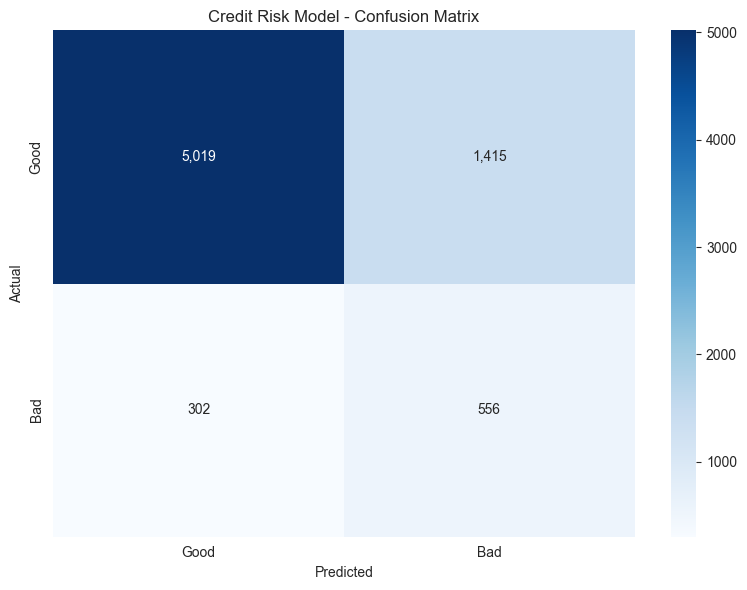

In [91]:
y_prob = rf_search.best_estimator_.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

f2_scores = (5 * precisions[:-1] * recalls[:-1]) / (4 * precisions[:-1] + recalls[:-1] + 1e-10)
best_threshold = thresholds[f2_scores.argmax()]

print(f"Optimal F2 threshold: {best_threshold:.3f}")

print("\n" + "=" * 60)
print("📊 SMOTE MODEL EVALUATION (F2 Optimized)")
print("=" * 60)
y_pred_final = (y_prob >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_final, target_names=['Good', 'Bad']))
print(f"\nF2 Score: {fbeta_score(y_test, y_pred_final, beta=2):.3f}")

# CONFUSION MATRIX - MOVE IT HERE
cm = confusion_matrix(y_test, y_pred_final)  # FIXED: use y_pred_final

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt=',d',
    cmap='Blues',
    xticklabels=['Good', 'Bad'],
    yticklabels=['Good', 'Bad'],
    ax=ax
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Credit Risk Model - Confusion Matrix')
plt.tight_layout()
plt.show()